Code for analyzing excitability-based modulation of info flow through LIF ntwks.

In [1]:
%matplotlib inline
from copy import deepcopy
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import networkx as nx
import numpy as np

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

import _1A

In [2]:
SEED = Generic(NTWK=0, DRIVE=0, AB=0, PATH=0)

MAX_SEED = 2**32 - 1

E_L_1 = -0.046  # hyperexcitable voltage (V)

N = 100  # num nrns
FRQ_UP = 429  # upstream stim freq (Hz)

Q = 0.1  # cxn density

GAMMA = 1.3141  # SF power-law coef

W_E_UP = 0.01  # upstream syn. weight
W_E_RCR = 0.00735  # rcr syn. weight

T_M = 0.05  # membrane time const (s)
E_L = -0.068  # membrane leak potential (V)
V_TH = -0.036  # spike threshold (V)
V_RESET = -0.068  # reset potential (V)
T_R = 0.002  # refrac per. (s)

E_E = 0  # exc syn. rev. potential (V)
T_E = 0.002  # exc syn time const (s)

DUR = 300  # smln dur
DT = 0.0005  # smln time step

T_START = 0.5  # analysis start time
DEL_T = 0.002  # time bin size for mutual info analysis
DS = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], dtype=int)  # integer delays (num time bins) for MI analysis

MAX_ITER = 10000

# derived grouped params

## sf ntwk
P_SF = GenericFlexible(
    # ntwk
    gamma=GAMMA, n=N, t_m=T_M, e_l=E_L, v_th=V_TH, v_reset=V_RESET, t_r=T_R,
    e_e=E_E, t_e=T_E, w_e_rcr=W_E_RCR, w_e_up=W_E_UP,
    
    # input & smln
    frq_up=FRQ_UP,
    dt=DT, dur=DUR, t_start=T_START, seed=SEED.NTWK)

# Check EPSP induced by excitatory cxn weight

In [ ]:
raise Exception

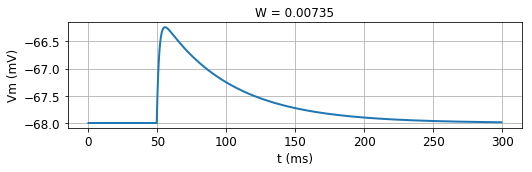

In [3]:
def test_epsp():
    
    ntwk_epsp = LIFNtwk(
        t_m=np.array([T_M]),
        e_l=np.array([E_L]),
        v_th=np.array([V_TH]),
        v_reset=np.array([V_RESET]),
        t_r=np.array([T_R]),
        es_syn={'E': E_E},
        ts_syn={'E': T_E},
        ws_rcr={'E': np.array([[0.]])},
        ws_up={'E': np.array([[W_E_RCR]])})

    t = np.arange(0, 0.3, DT)
    spks_up = np.zeros((len(t), 1))
    spks_up[int(0.05/DT), 0] = 1

    rsp = ntwk_epsp.run(spks_up=spks_up, dt=DT)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3), tight_layout=True)
    ax.plot(1000 * t, 1000 * rsp.vs[:, 0], lw=2)
    ax.grid()
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('Vm (mV)')
    ax.set_title('W = {}'.format(W_E_RCR))
    set_font_size(ax, 12)
    
test_epsp()

# Show shortest path length distributions for different N in SF ntwk

In [ ]:
raise Exception

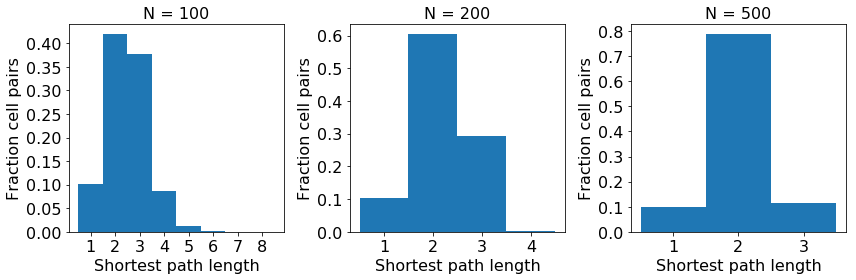

In [4]:
def plot_shortest_paths_vs_n():
    save = GenericFlexible()
    
    n_ntwks = 10
    ns = [100, 200, 500]  # num nrns
    gammas = [1.3141, 1.2240, 1.14379]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
    
    for n, gamma, ax in zip(ns, gammas, axs):
        spls = []
        
        for _ in range(n_ntwks):
            # make graph
            seed = np.random.randint(0, MAX_SEED)
            adj = _1A.dctd_p_law_adj(n, gamma, seed)
            g = nx.from_numpy_array(adj.T, create_using=nx.DiGraph())
            
            # get shortest path lengths
            spl_gntr = nx.shortest_path_length(g)
            for src, spls_src in spl_gntr:
                spls.extend(spls_src.values())
        
        bins = np.arange(np.max(spls) + 1) + 0.5
        ax.hist(spls, bins=bins, normed=True)
        ax.set_xticks(np.arange(np.max(spls)) + 1)
        
    for n, ax in zip(ns, axs):
        ax.set_xlabel('Shortest path length')
        ax.set_ylabel('Fraction cell pairs')
        ax.set_title('N = {}'.format(n))
        
        set_font_size(ax, 16)
    
plot_shortest_paths_vs_n()

# Test baseline ntwk

In [ ]:
raise Exception

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


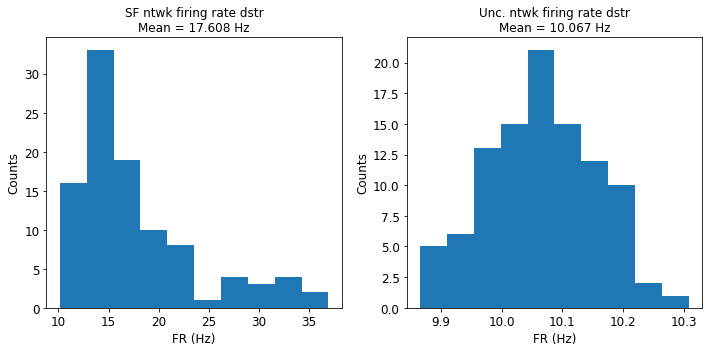

In [4]:
def test_baseline_ntwk():
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
    
    # make frozen noise stim
    np.random.seed(SEED.DRIVE)

    t = np.arange(0, P_SF.dur, P_SF.dt)
    spks_up = np.random.poisson(P_SF.frq_up * P_SF.dt, (len(t), P_SF.n))
    
    # make and run SF ntwk

    ## make ntwk
    STORE = GenericFlexible()
    ntwk_0 = _1A.sf_ntwk(P_SF, STORE)[0]

    ## drive sf ntwk
    rsp_0 = ntwk_0.run(spks_up, P_SF.dt)

    ## get firing rates
    t_mask = (P_SF.t_start <= rsp_0.ts)
    fr_0 = rsp_0.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

    axs[0].hist(fr_0)
    axs[0].set_xlabel('FR (Hz)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title('SF ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_0.mean()))

    set_font_size(axs[0], 12)
    
    # make and run equiv. unc ntwk
    
    ## make ntwk
    ntwk_unc = deepcopy(ntwk_0)
    ntwk_unc.ws_rcr['E'][:] = 0

    ## drive unc ntwk
    rsp_unc = ntwk_unc.run(spks_up, P_SF.dt)

    # plot firing rates
    t_mask = (P_SF.t_start <= rsp_unc.ts)
    fr_unc = rsp_unc.spks[t_mask, :].sum(0) / (P_SF.dur - P_SF.t_start)

    axs[1].hist(fr_unc)
    axs[1].set_xlabel('FR (Hz)')
    axs[1].set_ylabel('Counts')
    axs[1].set_title('Unc. ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_unc.mean()))

    set_font_size(axs[1], 12)
    
test_baseline_ntwk()

# Run example smln

## Make random EPSP drive

In [3]:
# make frozen noise stim
np.random.seed(SEED.DRIVE)

t = np.arange(0, P_SF.dur, P_SF.dt)
spks_up = np.random.poisson(P_SF.frq_up * P_SF.dt, (len(t), P_SF.n))

## Generate and run random SF ntwk

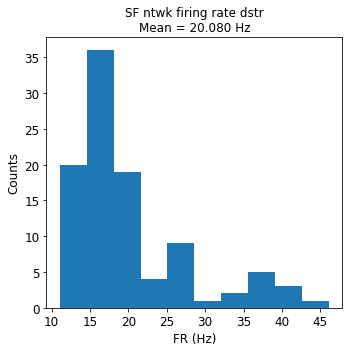

In [4]:
np.random.seed(SEED.NTWK)

p_sf = deepcopy(P_SF)
p_sf.seed = np.random.randint(MAX_SEED)

# make ntwk
STORE = GenericFlexible()
ntwk_0 = _1A.sf_ntwk(p_sf, STORE)[0]

# drive ntwk
rsp_0 = ntwk_0.run(spks_up, p_sf.dt)

# get time-avgd pop. fr dstr
t_mask = (p_sf.t_start <= rsp_0.ts)
fr_0 = rsp_0.spks[t_mask, :].sum(0) / (p_sf.dur - p_sf.t_start)

# plot fr dstr
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.hist(fr_0)

ax.set_xlabel('FR (Hz)')
ax.set_ylabel('Counts')
ax.set_title('SF ntwk firing rate dstr\nMean = {0:.3f} Hz'.format(fr_0.mean()))
set_font_size(ax, 12)

# Define binning and MI fns

In [5]:
def bin_spks(spks, t, del_t, max_one_spk, ignore_rmd=True):
    """Bin multi-variate spike train.
    
    :param ignore_rmd: ignore final time bin if incomplete (i.e. if nonzero remainder)
    :return: binned times, spks
    """
    assert len(spks) == len(t)
    
    # get approx num dt per time bin
    dt = np.mean(np.diff(t))
    n_dt = int(np.round(del_t/dt))
    
    # convert 2D array to "stacked" 3D array
    ## get num layers
    n_layers = int(np.ceil(len(t) / n_dt))
    
    ## get cut indicating start of last layer (which might be shorter than prev layers)
    cut = (n_layers-1) * n_dt
    
    ## init array
    spks_stacked = np.zeros((n_layers, n_dt, spks.shape[1]), dtype=bool)
    
    # #fill in all but final layer
    spks_stacked[:n_layers-1] = np.split(spks[:cut], n_layers-1)
    
    ## fill in final layer
    spks_stacked[-1][:len(spks) - cut] = spks[cut:]
    
    # repeat with time vec
    t_stacked = np.nan * np.zeros((n_layers, n_dt))
    t_stacked[:n_layers-1] = np.split(t[:cut], n_layers-1)
    t_stacked[-1][:len(spks) - cut] = t[cut:]
    
    # get binned spk cts by taking sum over middle axis
    spks_binned = np.sum(spks_stacked, 1)
    # get corresponding times (nanmean since last bin might be incomplete)
    t_binned = np.nanmean(t_stacked, 1)
    
    if max_one_spk: 
        spks_binned[spks_binned > 0] = 1
        
    if len(t) % n_dt:
        return spks_binned[:-1].astype(int), t_binned[:-1]
    else:
        return spks_binned.astype(int), t_binned
    

def calc_mi(spks_binned, idx_a, idx_b, ds):
    """
    Naive mutual info calc between binned spike trains of two cells at set of integer delays.
    
    "Naive" because calcs MI from unbiased estimate of probs (but this will underestimate MI).
    
    Note: positive d means looking at b spks occurring after a spks
        (i.e. positive d is for a-->b causality)
    
    :return: list of MIs, one for each d
    """
    spks_binned = spks_binned.astype(bool)
    
    spks_binned_a = spks_binned[:, idx_a]
    spks_binned_b = spks_binned[:, idx_b]
    
    mis = []
    ps = []
    
    for d in ds:
        if d == 0:
            spks_binned_a_d = spks_binned_a
            spks_binned_b_d = spks_binned_b
        elif d > 0:
            spks_binned_a_d = spks_binned_a[:-d]
            spks_binned_b_d = spks_binned_b[d:]
        elif d < 0:
            spks_binned_a_d = spks_binned_a[-d:]
            spks_binned_b_d = spks_binned_b[:d]
        
        # estimate probabilities
        p_a = spks_binned_a_d.mean()  # p(a=1)
        p_b = spks_binned_b_d.mean()  # p(b=1)
        
        p_00 = ((~spks_binned_a_d) & (~spks_binned_b_d)).mean()  # p(a=0, b=0)
        p_10 = (spks_binned_a_d & (~spks_binned_b_d)).mean()  # p(a=1, b=0)
        p_01 = ((~spks_binned_a_d) & spks_binned_b_d).mean()  # p(a=0, b=1)
        p_11 = (spks_binned_a_d & spks_binned_b_d).mean()  # p(a=1, b=1)
        
        np.testing.assert_almost_equal(p_00 + p_10 + p_01 + p_11, 1)
        
        mi = 0
        
        if p_00:
            mi += (p_00 * (np.log2(p_00) - np.log2((1-p_a) * (1-p_b))))
        if p_10:
            mi += (p_10 * (np.log2(p_10) - np.log2(p_a * (1-p_b))))
        if p_01:
            mi += (p_01 * (np.log2(p_01) - np.log2((1-p_a) * p_b)))
        if p_11:
            mi += (p_11 * (np.log2(p_11) - np.log2(p_a * p_b)))
            
        mis.append(mi)
        ps.append(Generic(p_a=p_a, p_b=p_b, p_00=p_00, p_10=p_10, p_01=p_01, p_11=p_11))
            
    return mis, ps

### Binning/MI tests

In [ ]:
raise Exception

#### Correctness test

In [6]:
def test_binning():
    spks = np.array([
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    ], dtype=bool).T
    t = np.array([0, .0005, .001, .0015, .002, .0025, .003, .0035, .004, .0045, .005, .0055, .006])
    del_t = 0.002
    
    spks_binned_desired = np.array([
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 0],
        [0, 1, 1],
    ]).T
    
    spks_binned_actual = bin_spks(spks, t, del_t, max_one_spk=True)[0]
    
    print('Desired:')
    print(spks_binned_desired)
    
    print('Actual:')
    print(spks_binned_actual)
    
    np.testing.assert_array_equal(spks_binned_actual, spks_binned_desired)
    
    print('\nTests passed.\n')
    
test_binning()


def test_calc_mi():
    spks_binned = np.array([
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 0
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 1
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],  # 2
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],  # 3
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],  # 4
    ], dtype=bool).T
    
    print('\nDesired: mi_00 == mi_01 == mi_10 > mi_02 > mi_03')
    
    mi_00 = calc_mi(spks_binned, 0, 0, ds=[0])[0][0]
    mi_01 = calc_mi(spks_binned, 0, 1, ds=[0])[0][0]
    mi_10 = calc_mi(spks_binned, 1, 0, ds=[0])[0][0]
    mi_02 = calc_mi(spks_binned, 0, 2, ds=[0])[0][0]
    mi_03 = calc_mi(spks_binned, 0, 3, ds=[0])[0][0]
    
    assert mi_00 == mi_01 == mi_10 > mi_02 > mi_03
    
    print('mi_00 = {}'.format(mi_00))
    print('mi_01 = {}'.format(mi_01))
    print('mi_10 = {}'.format(mi_01))
    print('mi_02 = {}'.format(mi_02))
    print('mi_03 = {}'.format(mi_03))
    
    print('\nDesired: mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0')
    
    mi_40_ds = calc_mi(spks_binned, 4, 0, ds=[0, 1, 2])[0]
    mi_40_d_2 = mi_40_ds[2]
    mi_40_d_0 = mi_40_ds[0]
    
    mi_04_ds = calc_mi(spks_binned, 0, 4, ds=[0, -1, -2])[0]
    mi_04_d_neg2 = mi_04_ds[2]
    mi_04_d_0 = mi_04_ds[0]
    
    assert mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0
    
    print('mi_40_d_2 = {}'.format(mi_40_d_2))
    print('mi_04_d_neg2 = {}'.format(mi_04_d_neg2))
    print('mi_40_d_0 = {}'.format(mi_40_d_0))
    print('mi_04_d_0 = {}'.format(mi_04_d_0))
    
    print('\nTests passed.\n')
    
test_calc_mi()

Desired:
[[1 0 1 0]
 [0 1 1 1]
 [1 1 0 1]]
Actual:
[[1 0 1 0]
 [0 1 1 1]
 [1 1 0 1]]

Tests passed.


Desired: mi_00 == mi_01 == mi_10 > mi_02 > mi_03
mi_00 = 0.9366673818775626
mi_01 = 0.9366673818775626
mi_10 = 0.9366673818775626
mi_02 = 0.5548894409556177
mi_03 = 0.03266352574517187

Desired: mi_40_d_2 == mi_04_d_neg2 > mi_40_d_0 == mi_04_d_0
mi_40_d_2 = 0.9709505944546686
mi_04_d_neg2 = 0.9709505944546686
mi_40_d_0 = 0.03673442288657437
mi_04_d_0 = 0.03673442288657437

Tests passed.



#### Time elapsed test

In [7]:
def test_bin_spks_calc_mi_time():
    
    for del_t in [0.005, 0.002]:

        tic = time.time()
        spks_0_binned = bin_spks(rsp_0.spks, rsp_0.ts, del_t=del_t, max_one_spk=True)[0]
        toc = time.time()

        print('Time elapsed for binning {} s smln at DT = {} ms and bins {} ms:'.format(DUR, 1000*DT, 1000*del_t))
        print('{0:.3f} s\n'.format(toc - tic))
        
        ds = [0, 1, 2, 3]
        tic = time.time()
        mis, ps = calc_mi(spks_0_binned, 20, 50, ds=ds)
        toc = time.time()
        
        print('Time elapsed to calc 2-cell MI at d = {}'.format(ds))
        print('{0:.6f} s\n'.format(toc - tic))
        
test_bin_spks_calc_mi_time()

Time elapsed for binning 300 s smln at DT = 0.5 ms and bins 5.0 ms:
0.225 s

Time elapsed to calc 2-cell MI at d = [0, 1, 2, 3]
0.007709 s

Time elapsed for binning 300 s smln at DT = 0.5 ms and bins 2.0 ms:
0.485 s

Time elapsed to calc 2-cell MI at d = [0, 1, 2, 3]
0.025026 s



## Test MI comparison with SF ntwk copy w/ added A-->B direct cxn

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Running smln of ntwk with extra A-->B exc. synapse...
Binning spks...
Computing MI...


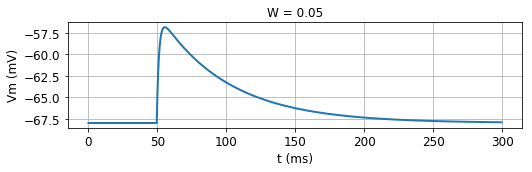

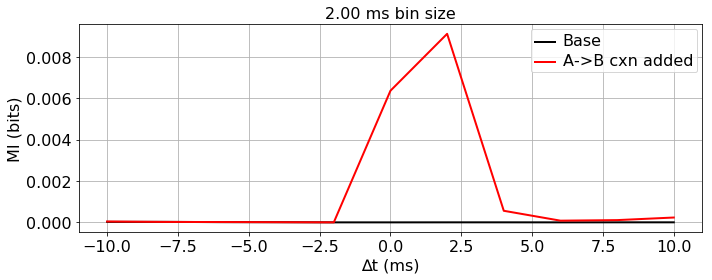

In [8]:
def test_mi_comparison():
    
    w_e_rcr_mi_test = 0.05
    
    def test_epsp():
    
        ntwk_epsp = LIFNtwk(
            t_m=np.array([T_M]),
            e_l=np.array([E_L]),
            v_th=np.array([V_TH]),
            v_reset=np.array([V_RESET]),
            t_r=np.array([T_R]),
            es_syn={'E': E_E},
            ts_syn={'E': T_E},
            ws_rcr={'E': np.array([[0.]])},
            ws_up={'E': np.array([[w_e_rcr_mi_test]])})

        t = np.arange(0, 0.3, DT)
        spks_up = np.zeros((len(t), 1))
        spks_up[int(0.05/DT), 0] = 1

        rsp = ntwk_epsp.run(spks_up=spks_up, dt=DT)

        fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5/3), tight_layout=True)
        ax.plot(1000 * t, 1000 * rsp.vs[:, 0], lw=2)
        ax.grid()
        ax.set_xlabel('t (ms)')
        ax.set_ylabel('Vm (mV)')
        ax.set_title('W = {}'.format(w_e_rcr_mi_test))
        set_font_size(ax, 12)
    
    test_epsp()
    
    # pick cells to add cxn btwn
    np.random.seed(SEED.AB)
    
    for _ in range(MAX_ITER):
        idx_a = np.random.randint(0, p_sf.n)
        idx_b = np.random.randint(0, p_sf.n)
        
        if idx_a == idx_b:
            continue
        elif ntwk_0.ws_rcr['E'][idx_b, idx_a] > 0:
            continue
        else:
            break
    else:
        raise Exception('Max iters reached finding (A, B)')
        
    # create and run copy of ntwk_0 with added A->B strong E cxn
    
    ## make initial copy
    ntwk_ab_cxn = deepcopy(ntwk_0)
    
    ## add cxn
    ntwk_ab_cxn.ws_rcr['E'][idx_b, idx_a] = w_e_rcr_mi_test
    
    ## run smln
    print('Running smln of ntwk with extra A-->B exc. synapse...')
    rsp_ab_cxn = ntwk_ab_cxn.run(spks_up, p_sf.dt)
    
    # calc A-->B MI for both neurs
    del_t = 0.002
    
    print('Binning spks...')
    spks_binned_0 = bin_spks(rsp_0.spks, rsp_0.ts, del_t, max_one_spk=True)[0]
    spks_binned_ab_cxn = bin_spks(rsp_ab_cxn.spks, rsp_ab_cxn.ts, del_t, max_one_spk=True)[0]
    
    ds = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], dtype=int)
    
    print('Computing MI...')
    mis_0 = calc_mi(spks_binned_0, idx_a, idx_b, ds)[0]
    mis_ab_cxn = calc_mi(spks_binned_ab_cxn, idx_a, idx_b, ds)[0]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
    ax.plot(1000 * del_t * ds, mis_0, c='k', lw=2)
    ax.plot(1000 * del_t * ds, mis_ab_cxn, c='r', lw=2)
    
    ax.set_xlabel('∆t (ms)')
    ax.set_ylabel('MI (bits)')
    ax.set_title('{0:.2f} ms bin size'.format(1000 * del_t))
    ax.legend(['Base', 'A->B cxn added'])
    
    ax.grid()
    
    set_font_size(ax, 16)
    
test_mi_comparison()

# Estimate MI variance for given smln dur

## Pick random connected cell pairs


Cell pair 1:
Running smlns
.....
Cell pair 2:
Running smlns
.....
Cell pair 3:
Running smlns
.....
Cell pair 4:
Running smlns
.....
Cell pair 5:
Running smlns
.....
Cell pair 6:
Running smlns
.....
Cell pair 7:
Running smlns
.....
Cell pair 8:
Running smlns
.....
Cell pair 9:
Running smlns
.....
Cell pair 10:
Running smlns
.....
Cell pair 11:
Running smlns
.....
Cell pair 12:
Running smlns
.....
Cell pair 13:
Running smlns
.....
Cell pair 14:
Running smlns
.....
Cell pair 15:
Running smlns
.....

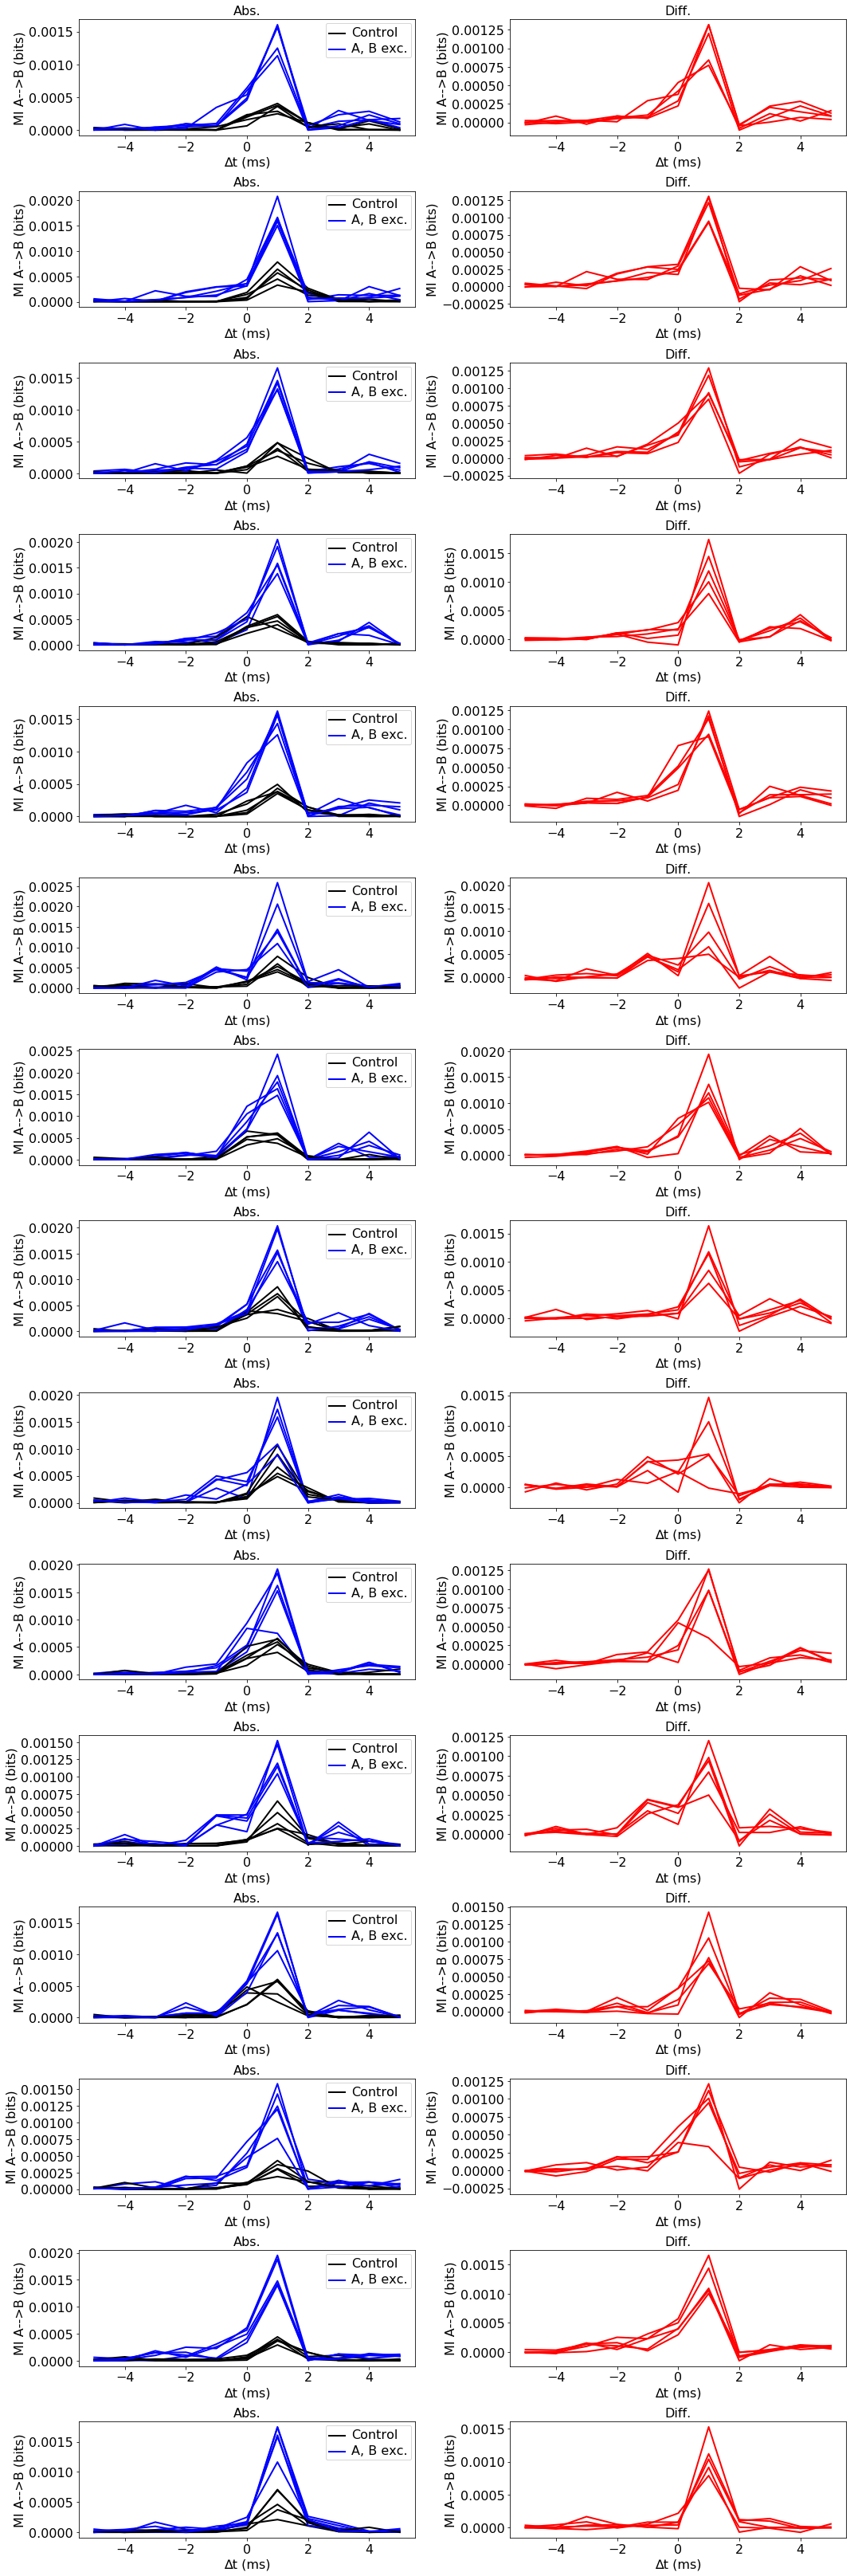

In [10]:
def test_mi_variance():
    
    np.random.seed(0)
    
    N_PAIRS = 15
    N_TRIALS = 5
    DUR = 150
    
    rslt = GenericFlexible()
    rslt.ntwk = ntwk_0
    rslt.nrns_hyper = []
    rslt.frs_0 = []
    rslt.frs_1 = []
    
    fig, axs = plt.subplots(N_PAIRS, 2, figsize=(15, 3*N_PAIRS), tight_layout=True)
    
    for ar_ctr, ax_row in enumerate(axs):
        
        print('\nCell pair {}:'.format(ar_ctr+1))
        
        # get cell pair
        for _ in range(MAX_ITER):
            idx_a = np.random.randint(0, p_sf.n)
            idx_b = np.random.randint(0, p_sf.n)

            if idx_a == idx_b:
                continue
            if ntwk_0.ws_rcr['E'][idx_b, idx_a] > 0:
                break
        else:
            raise Exception('Max iters reached finding (A, B)')
            
        nrns_hyper = [idx_a, idx_b]
        
        rslt.nrns_hyper.append(nrns_hyper)
        
        # increase A, B excitabilities
        ntwk_1 = deepcopy(ntwk_0)
        
        ntwk_1.e_l[nrns_hyper] = E_L_1
        ntwk_1.v_reset[nrns_hyper] = E_L_1
        
        # loop over smlns
        print('Running smlns')
        
        frs_0 = [[], []]
        frs_1 = [[], []]
        
        for _ in range(N_TRIALS):
            
            # gen ntwk drive
            t = np.arange(0, DUR, P_SF.dt)
            spks_up = np.random.poisson(P_SF.frq_up * P_SF.dt, (len(t), P_SF.n))
            
            # drive ntwks
            rsp_0 = ntwk_0.run(spks_up, p_sf.dt)
            rsp_1 = ntwk_1.run(spks_up, p_sf.dt)
            
            sys.stdout.write('.')
            
            # bin spks & calc mi
            spks_binned_0 = bin_spks(rsp_0.spks, rsp_0.ts, DEL_T, max_one_spk=True)[0]
            mis_0 = np.array(calc_mi(spks_binned_0, idx_a, idx_b, DS)[0])
            spks_binned_1 = bin_spks(rsp_1.spks, rsp_1.ts, DEL_T, max_one_spk=True)[0]
            mis_1 = np.array(calc_mi(spks_binned_1, idx_a, idx_b, DS)[0])
            
            # get firing rates of A & B neurons
            frs_0[0].append(rsp_0.spks[:, idx_a].sum()/DUR)
            frs_0[1].append(rsp_0.spks[:, idx_b].sum()/DUR)
            frs_1[0].append(rsp_1.spks[:, idx_a].sum()/DUR)
            frs_1[1].append(rsp_1.spks[:, idx_b].sum()/DUR)
            
            # plot initial, final, and diff
            ax_row[0].plot(DS, mis_0, c='k', lw=2)
            ax_row[0].plot(DS, mis_1, c='b', lw=2)
            ax_row[0].legend(['Control', 'A, B exc.'])
            ax_row[1].plot(DS, mis_1 - mis_0, c='r', lw=2)
            
        rslt.frs_0.append([np.mean(frs_0[0]), np.mean(frs_0[1])])
        rslt.frs_1.append([np.mean(frs_1[0]), np.mean(frs_1[1])])
            
        ax_row[0].set_title('Abs.')
        ax_row[1].set_title('Diff.')

        for ax in ax_row:
            ax.set_xlabel('∆t (ms)')
            ax.set_ylabel('MI A-->B (bits)')
            
            set_font_size(ax, 16)
            
    return rslt
            
test_mi_variance_rslt = test_mi_variance()

Black is before A & B excitability increase, blue is after. This shows that MI estimate is pretty low-variance given this duration.